# Trabajo Práctico 1 - Procesamiento Digital de Señales
Desarrollado por Martín Haimovich e Ignacio Veiga, UNTREF, Octubre de 2022. 

Se destaca la importancia de ejecutar las celdas del presente Notebook de forma secuencial, para asegurar su correcto funcionamiento.

Versión de Python utilizada para el desarrollo: 3.10.0

Para ciertas funcionalidades puede ser necesario actualizar la versión de nbformat (pip install --upgrade nbformat).

### Ejercicio 1

Se importan las bibliotecas necesarias

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

Defino los parametros de frecuencia, frecuencia de muestreo, numero de armonicos, tiempo y la cantidad de muestras por 2 segundos.

In [9]:
f0 = 440
fs = 44100
K = 5
signalTime = 2

N = (signalTime*fs)//1

Defino un vector n cuyos elementos irán desde 0 hasta el numero de muestra que se encuentra en el segundo 2, genero el vector tiempo de 2 segundos y defino un vector A que esta lleno de ceros, cuya cantidad de elementos es igual a las muestras en 2 seg (N).

In [10]:
n = np.arange(N)
t = np.linspace(0,2,N)
A = np.zeros(N)

Voy agregandole elementos al vector A (armonicos) y grafico cada armonico. Finalmente, normalizo y grafico la señal completa.

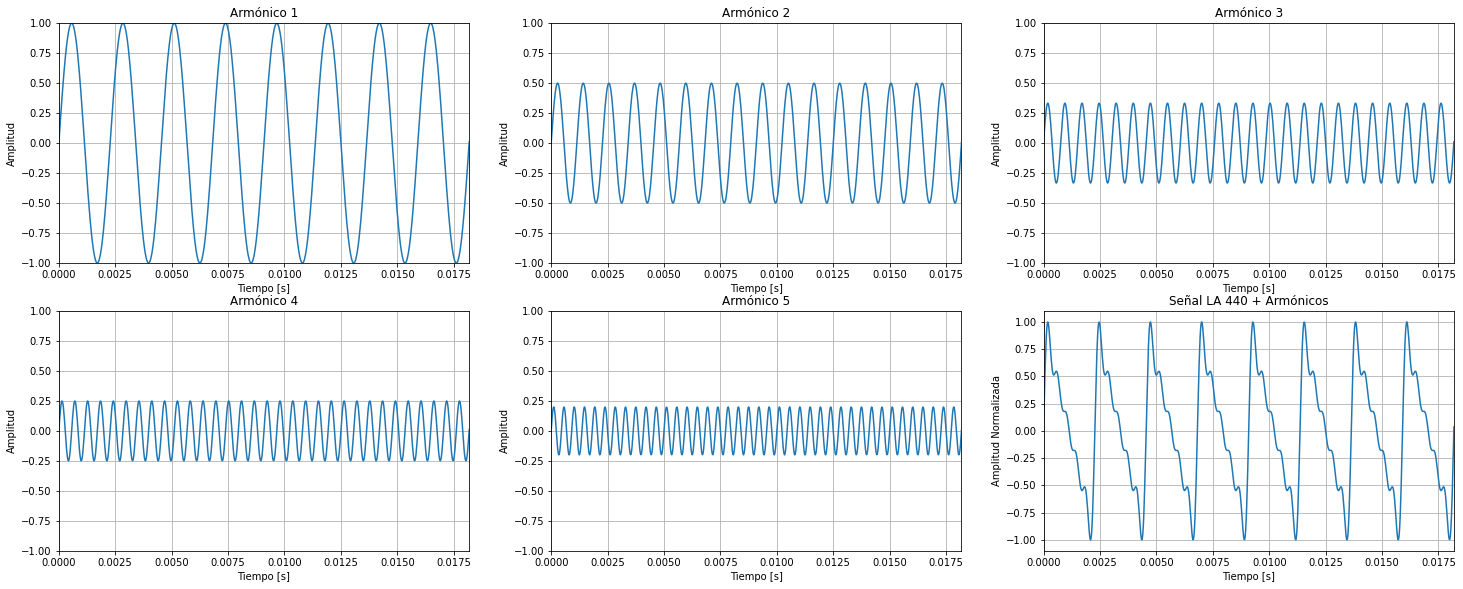

In [12]:
plt.figure(figsize=(25,15))
for k in range(1,K+1):
    armonicos = (1/k) * np.sin(2*n*k*np.pi*(f0/fs))
    A += armonicos
    plt.subplot(3,3,k)
    plt.plot(t,armonicos)
    plt.grid()
    plt.xlim(0,(8/f0))
    plt.ylim(-1,1)
    plt.title('Armónico %i' %k)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")   

Amax = np.amax(A)
A = A * (1/Amax)

plt.subplot(3,3,6)
plt.plot(t,A)
plt.grid()
plt.xlim(0,(8/f0))
plt.title('Señal LA 440 + Armónicos')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud Normalizada")
plt.show()

Se puede ver que la señal resultante se aproxima a una diente de sierra.